<img src="9-ride-sharing-frequency-analysis.jpg" alt="Video_games" style="width:700px;height:500px;">

<h1 style= 'font-family:Sabon; font-size:36.0pt;text-align:center;'>Analysis of Ride Frequency and Duration in Taxi and Ride-Sharing Companies</h1>

<span style='font-family:Sabon;font-size:24.0pt;'>
    <b>Table of Contents</b>
</span>
<span style='font-family:Sabon;font-size:16.0pt;line-height:1.5'>
    <ul>        
        <li><a href='#intro'>1. Introduction</a></li>
        <li><a href='#libraries'>2. Import Libraries</a></li>
        <li><a href='#functions'>3. Define Functions</a></li>
        <li><a href='#data'>4. Import Data</a></li>
        <li><a href='#gen_info'>5. General Information</a></li>        
        <ul>
            <li><a href='#gen_conc'>5.1 Conclusion</a></li>
        </ul>
        <li><a href='#preprocessing'>6. Preparing Data for Analysis</a></li>
        <ul>
            <li><a href='#pp_dup'>6.1 Finding Duplicated Rows</a></li>
            <li><a href='#pp_col_exp'>6.2 Individual Column Transformation</a></li>
            <li><a href='#pp_0val'>6.3 Removing Unrealistic Ride Durations</a></li>
            <li><a href='#pp_conc'>6.4 Conclusion</a></li>
        </ul>
        <li><a href='#analysis'>7. Analysis of the Data</a></li>
        <ul>
            <li><a href='#ana_top10loc'>7.1 Top 10 Frequented Locations</a></li>
            <li><a href='#ana_top10taxi'>7.2 Top 10 Taxi Companies</a></li>
            <li><a href='#ana_IQR'>7.3 Interquartile Analysis of Ride Duration</a></li>
            <li><a href='#ana_conc'>7.4 Conclusion</a></li>
        </ul>
        <li><a href='#hypo'>8. Testing Hypotheses</a></li>
            <ul>
                <li><a href='#h1'>8.1 Hypothesis 1</a></li>
                <ul>
                    <li><a href='#h1s'>8.1.1 Shapiro Test</a></li>
                    <li><a href='#h1l'>8.1.2 Levene Test</a></li>
                    <li><a href='#h1t'>8.1.3 T-test</a></li>
                    <li><a href='#h1mw'>8.1.4 Mann Whitney U Test</a></li>
                </ul>
                <li><a href='#hypo_conc'>8.3 Conclusion</a></li>
            </ul>    
        <li><a href='#overall_conc'>9. Overall Conclusion</a></li>        
    </ul>
</span>

<a id="intro"></a>
<h2>Introduction</h2>

<span style='font-family:sabon;font-size:13pt;'>
    In this project we take the part of employees of an up and coming ride-sharing company in Chicago.<br>As such, we will take a look at data from different taxi and ride-sharing companies to determine certain patterns such as passenger preferences, popular locations and effects of external factors such as weather on rides.<br><br>
    In order to achieve this, we will analyse three sets of data concerning <b>dropoff locations</b>, <b>ride durations</b> and <b>weather status</b>.<br>
    Using the data at our disposal we will form a hypothesis concerning the <b>impact of weather conditions on ride frequency</b>.
</span>

<a id="libraries"></a>
<h2>Import Libraries</h2>

In [1]:
#update plotly module
!pip install -q plotly --upgrade

In [2]:
#import relevant libraries
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

<a id="functions"></a>
<h2>Define Functions</h2>

In [3]:
def zn_values(df):
    """
    
    This function accepts a dataframe
    and produces a report of the presence
    of 0 values in each column.
    
    """
    #loop over each column and count how many 0 values it contains
    for col in df.columns:
        z_values = df[df[col] == 0].shape[0]

        print('Column name: {}\nValues that equal 0: {}\n'.format(
            col,z_values
        )
             )

def sample_display(df_list,n=5):
    """
    This function displays samples
    of all the dataframes in the list.
    n rows default 5
        
    Parameters:
    
        df_list: list of pandas dataframes
    
        n (int): number of sample rows to return
        
    Returns:
    
        n sample rows from each df listed
    
    """
    alias= 0
    for df in df_list:
        try:
            df_name = df.custom_name
        except:
            df_name = 'Unknown Dataframe {}'.format(alias)
            alias += 1
        print('{} sample:'.format(df_name))
        display(df.sample(n))
        
def shapiro_result(array,alpha=0.05):
    """
    
    This function performs the shapiro
    test on an array, to test whether 
    the distribution is normal or not
    and produces a q-q plot for the array.
    The default alpha value is 0.05
    
    """
    if np.isnan(array).any():
        return('Eliminate null values before running this function')
    test= st.shapiro(array)
    #results
    if test[1] <= alpha:
        print(
            'pvalue is {}\nWe reject the null hypothesis\nNo significant evidence for normal distribution'\
            .format(test[1])
             )
    else:
        print(
            'pvalue is {}\nWe cannot reject the null hypothesis\nThere is significant evidence for normal distribution'\
            .format(test[1])
        )
    st.probplot(array, dist="norm", plot=plt)
    plt.show()
        
def levene_result(array_x, array_y, alpha=0.05):
    """
    
    This function performs the levene
    test on two arrays, to test whether 
    their variance is similar or not.
    The default alpha value is 0.05
    
    parameters:
        array_x, array_y : samples to be tested
        alpha(int): statistical significance level (default= 0.05)
    
    """
    if np.isnan(array_x).any() or np.isnan(array_y).any():
        return('Eliminate null values before running this function')
    test= st.levene(array_x,array_y)
    #results
    if test[1] <= alpha:
        print(
            'pvalue is {}\nWe reject the null hypothesis\nNo significant evidence for equal variance'\
            .format(test[1])
        )
    else:
        print(
            'pvalue is {}\nWe cannot reject the null hypothesis\nThere is significant evidence for equal variance'\
            .format(test[1])
        )

def ttest_ind_result(array_x, array_y, equal_var, alpha=0.05):
    """
    
    This function performs a ttest on a sample
    of independent arrays to test the hypothesis
    that their mean is equal.
    The default alpha value is 0.05
    
    parameters:
        array_x (array) : first sample
        array_y (array) : second sample
        equal_var (bool) : if True, assume equal variances(standard t test),
                           if False, assume unequal variances (welch)
        alpha (float) : statistical significance level
        
    
    """
    if np.isnan(array_x).any() or np.isnan(array_y).any():
        return('Eliminate null values before running this function')
    pvalue= st.ttest_ind(array_x,array_y,equal_var= equal_var)[1]
    #results
    if pvalue <= alpha:
        reject_h0 = 1
        print('pvalue is {}\nWe reject the null hypothesis'.format(pvalue))
    else:
        reject_h0 = 0
        print('pvalue is {}\nWe cannot reject the null hypothesis'.format(pvalue))
        
    result_col = ['sample_1', 'sample_2', 'alpha', 'p_value', 'reject_h0']
    result_row = [array_x.name, array_y.name, alpha, round(pvalue,3), reject_h0]
    display(pd.DataFrame(data=np.array([result_row]),columns= result_col))
    print('_____________________________________________\n')
    
def dup_display(df_list):
    """
    This function returns the
    number of duplicated rows
    in each df in the list
        
    Parameters:
        df_list: list of pandas dataframes
    
    Returns:
        report of duplicated rows in each df listed
        report of duplicates diversity in each df listed
    
    """
    alias= 0
    for df in df_list:
        dup_sum = df.duplicated().sum()
        dup_perc = dup_sum / df.shape[0]
        try:
            df_name = df.custom_name
        except:
            df_name = 'Unknown Dataframe {}'.format(alias)
            alias += 1
        
        print('{} :\nDuplicated Values: {}\n% duplicated rows: {:.2%}\n'.format(
            df_name,dup_sum,dup_perc
        )
             )
        print('Duplicates distribution diversity:')
        for col in df[df.duplicated()].columns:
            print('{} : {}'.format(
                col,df[df.duplicated()][col].nunique()
        )
             )
        print()
        
def mann_whitney_result(sample_a,sample_b,alpha=0.05):
    """
    
    This function performs the Mann-Whitney U
    test on two given samples to test whether 
    they belong to the same statistical population or not.
    
    Parameters:
        sample_a: first sample to be tested
        sample_b: second sample to be tested
        alpha(float): Statistical significance level (default 0.05)
        
    Returns:
        The result of the hypothesis test, the alpha value used and the pvalue
    
    """
    test= st.mannwhitneyu(sample_a, sample_b)
    sample_a_avg = round(sample_a.mean(),2)
    sample_b_avg = round(sample_b.mean(),2)
    #results
    if test[1] <= alpha:
        print(
            'Significance Level: {}\npvalue is {:.4f}\nWe reject the null hypothesis\nNo significant evidence that the two statistical populations are the same'\
            .format(alpha,test[1])
             )
        reject_h0 = 1
    else:
        print(
            'Significance Level: {}\npvalue is {:.4f}\nWe cannot reject the null hypothesis\nThere is no significant evidence that the populations are not the same'\
            .format(alpha,test[1])
        )
        reject_h0 = 0
    #produce report
    result_col = ['sample_1','sample_1_avg', 'sample_2','sample_2_avg', 'alpha', 'p_value', 'reject_h0']
    result_row = [sample_a.name, sample_a_avg,sample_b.name,sample_b_avg, alpha, round(test[1],3), reject_h0]
    display(pd.DataFrame(data=np.array([result_row]),columns= result_col))
        

<a id="data"></a>
<h2>Import Data</h2>

In [4]:
#load data 
dropoff = pd.read_csv(
    'dropoff.csv',
    index_col=[0]
)
trips = pd.read_csv(
    'trips.csv',
    index_col=[0]
)
trip_conditions = pd.read_csv(
    'loop_ohare.csv',
    index_col=[0],
    parse_dates=['start_ts']
                        )

#set name for reference
dropoff.custom_name = 'dropoff'
trips.custom_name = 'trips'
trip_conditions.custom_name = 'trip_conditions'

<a id="gen_info"></a>
<h2>General Information</h2>

<a id='gen_cols'></a>
<h3>Column Breakdown</h3>

<span style='font-family:sabon;font-size:13pt;'> For this project we have 3 datasets: <br>
  <br>
  <b>
    <u>Trips Data:</u>
  </b>
  <ul>
    <li>Company_name: This column contains the names of ride sharing and taxi companies.</li>
    <li>trips_amount: This column contains the amount of trips each company delivered.</li>
  </ul>
  <b>
    <u>Dropoffs Data:</u>
  </b>
  <ul>
    <li>dropoff_location_name: This column contains the names dropoff locations.</li>
    <li>average_trips: This column contains the average trips by all companies, made to a dropoff location.</li>
  </ul>
  <b>
    <u>trip_conditions Data:</u>
  </b>
    This dataset contains information regarding rides from Loop to O'Hare International Airport.
  <ul>
    <li>start_ts: This column contains the timestamp of the beginning of the ride.</li>
    <li>weather_conditions: This column contains information regarding the weather conditions.</li>
    <li>duration_seconds: This column contains the duration of the trip in seconds.</li>
  </ul>
</span>

In [5]:
#show data samples
sample_display([trips, dropoff, trip_conditions])

trips sample:


company_name  trips_amount
61  5874 - 73628 Sergey Cab Corp.             5
33               Metro Jet Taxi A           146
12      Dispatch Taxi Affiliation          3355
26                Gold Coast Taxi           428
52      3721 - Santamaria Express            14

dropoff sample:


dropoff_location_name  average_trips
12     Little Italy, UIC     863.700000
31       Lower West Side     143.300000
10          Lincoln Park    1246.533333
70          Wrigleyville      14.233333
33          Portage Park     119.733333

trip_conditions sample:


start_ts weather_conditions  duration_seconds
382 2017-11-11 11:00:00               Good            1140.0
254 2017-11-04 14:00:00               Good            3120.0
443 2017-11-18 03:00:00               Good            1259.0
140 2017-11-04 12:00:00               Good            2760.0
672 2017-11-18 17:00:00                Bad            3022.0

In [6]:
#show data info
trips.info(memory_usage= 'deep'),
dropoff.info(memory_usage= 'deep'),
trip_conditions.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 5.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 7.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   objec

In [7]:
#display descriptive statistics for the data
display(trips.describe().T)
display(dropoff.describe().T)
display(trip_conditions.describe().T)

count         mean          std  min    25%    50%     75%  \
trips_amount   64.0  2145.484375  3812.310186  2.0  20.75  178.5  2106.5   

                  max  
trips_amount  19558.0

count        mean          std  min        25%        50%  \
average_trips   94.0  599.953728  1714.591098  1.8  14.266667  52.016667   

                      75%           max  
average_trips  298.858333  10727.466667

count         mean         std  min      25%     50%  \
duration_seconds  1068.0  2071.731273  769.461125  0.0  1438.25  1980.0   

                     75%     max  
duration_seconds  2580.0  7440.0

In [8]:
#use predefined function zn_values to detect 0 values
for df in [trips, dropoff, trip_conditions]:
    zn_values(df)

Column name: company_name
Values that equal 0: 0

Column name: trips_amount
Values that equal 0: 0

Column name: dropoff_location_name
Values that equal 0: 0

Column name: average_trips
Values that equal 0: 0

Column name: start_ts
Values that equal 0: 0

Column name: weather_conditions
Values that equal 0: 0

Column name: duration_seconds
Values that equal 0: 6



<a id="gen_conc"></a>
<h3>Conclusion</h3>

<span style='font-family:sabon;font-size:13pt;'> From checking the general info and statistics of the data we find: <br>
  <br>
  <b>
    <u>Trips Data:</u>
  </b>
  <ul>
    <li>The table contains <b>64</b> rows, each containing a unique company's trip count. </li>
    <li>We see that the <b>median value is 178</b> trips while the <b>average is 2145</b>, suggesting that some companies are far more popular than others, thus driving the average up. </li>
    <li>The table contains no null values.</li>
    <li>The company names are case sensitive, we will change them to lower case for easier analysis</li>
  </ul>
  <b>
    <u>Dropoffs Data:</u>
  </b>
  <ul>
    <li>The table contains <b>94</b> rows, each containing a unique dropoff location and the average amount of trips taken to that location. </li>
    <li>We see that the <b>median value is 52</b> dropoffs while the <b>average is 600</b>, suggesting that some locations are more frequented than others, thus driving the average up. </li>
    <li>The table contains no null values.</li>
    <li>The average_trips column datatype is <b>float64</b>, we will round it and assign it the <b>int16</b> datatype during preprocessing </li>
    <li>The location names are case sensitive, we will change them to lower case for easier analysis</li>
  </ul>
  <b>
    <u>trip_conditions Data:</u>
  </b>
  <ul>
    <li>The table contains <b>1068</b> rows, each containing average ride duration from Loop to O'Hare International Airport on a saturday </li>
    <li>We see that the <b>median value is 1980</b> seconds while the <b>average is 2071</b>, suggesting that the ride times are distributed rather evenly around the mean and there are not many outlying extreme values </li>
    <li>The table contains no null values.</li>
    <li>The duration_seconds column contains <b>6</b> values that are <b>0</b>. </li>
    <li>The duration_seconds column datatype is <b>float64</b>, we will assign it the <b>int16</b> datatype during preprocessing </li>
    <li>The weather condition values are case sensitive, we will change them to lower case for easier analysis</li>
  </ul>
</span>

<a id="preprocessing"></a>
<h2>Preparing Data for Analysis</h2>

<a id="pp_dup"></a>
<h3>Checking for Duplicated Rows</h3>

In [9]:
#check how many duplicated rows exist in the data
dup_display([trips, dropoff, trip_conditions])

trips :
Duplicated Values: 0
% duplicated rows: 0.00%

Duplicates distribution diversity:
company_name : 0
trips_amount : 0

dropoff :
Duplicated Values: 0
% duplicated rows: 0.00%

Duplicates distribution diversity:
dropoff_location_name : 0
average_trips : 0

trip_conditions :
Duplicated Values: 197
% duplicated rows: 18.45%

Duplicates distribution diversity:
start_ts : 35
weather_conditions : 2
duration_seconds : 43



<span style='font-family:sabon;font-size:13pt;'> <b>Results:</b><br>
    <li>We found duplicated rows in the trips_conditions data.</li>
    Let's examine them.
</span>

In [10]:
#examine the duplicated rows
trip_conditions[trip_conditions.duplicated(keep=False)].sort_values(['start_ts','duration_seconds']).head(10)

start_ts weather_conditions  duration_seconds
462  2017-11-04 05:00:00               Good            1200.0
541  2017-11-04 05:00:00               Good            1200.0
681  2017-11-04 06:00:00               Good            1267.0
682  2017-11-04 06:00:00               Good            1267.0
332  2017-11-04 07:00:00               Good            1140.0
979  2017-11-04 07:00:00               Good            1140.0
231  2017-11-04 07:00:00               Good            1200.0
933  2017-11-04 07:00:00               Good            1200.0
561  2017-11-04 07:00:00               Good            1260.0
1020 2017-11-04 07:00:00               Good            1260.0

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>Results:</u>
  </b>
  <br> Only the trip_conditions data seems to contain duplicates. <br> However, since the data we have concerns rides from a specific point A to a specific point B, the duration column is likely to have closely resembling values, which may have been rounded down by some rule before they were given to us. <br> Therefore we will not be removing these from the data. </span>

<a id="pp_col_exp"></a>
<h3>Individual Column Transformation</h3>

<h4>Rounding and Assigning type to average_trips</h4>

In [11]:
#round and change datatype
dropoff['average_trips'] = dropoff['average_trips'].round().astype('int16')
dropoff[['average_trips']].head()

average_trips
0          10727
1           9524
2           6665
3           5164
4           2547

<h4>Assigning type to duration_seconds</h4>

In [12]:
#change datatype
trip_conditions['duration_seconds'] = trip_conditions['duration_seconds'].astype('int16')
trip_conditions[['duration_seconds']].head()

duration_seconds
0              2410
1              1920
2              1543
3              2512
4              1440

<h4>Transform case sensitive values</h4>

In [13]:
#transform values to lower case
dropoff['dropoff_location_name'] = dropoff['dropoff_location_name'].str.lower()
trips['company_name'] = trips['company_name'].str.lower()
trip_conditions['weather_conditions'] = trip_conditions['weather_conditions'].str.lower()

In [14]:
#display transformed data
sample_display([trips, dropoff, trip_conditions], n=2)

trips sample:


company_name  trips_amount
48  3623 - 72222 arrington enterprises            20
55           6057 - 24657 richard addo            13

dropoff sample:


dropoff_location_name  average_trips
86           west elsdon              6
85             montclare              6

trip_conditions sample:


start_ts weather_conditions  duration_seconds
301 2017-11-11 07:00:00               good              1500
596 2017-11-11 15:00:00               good              2280

<a id="pp_0val"></a>
<h3>Removing Unrealistic Ride Durations</h3>

<span style='font-family:sabon;font-size:13pt;'> We found that there are 0 second rides in the trip_conditions data. <br> These might be rides that were never actually executed or were cancelled. <br> We will also look at the distribution of the data to see if there are any outstanding outliers that make no sense. </span>

In [15]:
#generate distribution of ride duration
fig= px.histogram(
    trip_conditions,
    x='duration_seconds',
    title= "Distribution of Ride Durations From Loop to O'Hare International Airport",
    template='seaborn'
)
fig.update_traces(marker_color= '#003049')
fig.update_layout(
    font=dict(
        family="Arial Black",
        size=12
    ),
    title_x = 0.5
)

#add median indicator
fig.add_trace(
    go.Indicator(
        mode = 'number',
        title = 'Mean Ride Duration',
        value = trip_conditions['duration_seconds'].mean(),
        domain = dict(x=[0.1,0.95], y=[0.68,0.75])
    )
)

fig.show()

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>Results</u>
  </b>: <br> We can see the 0 values as well as rides that lasted 400-500 seconds and ones which lasted over 6000 seconds. <br> Since these extreme values are few and far between, we will remove them from our analysis. </span>

In [16]:
#remove values and reset index
trip_conditions = trip_conditions.query('6000 > duration_seconds > 500')
trip_conditions.reset_index(drop=True,inplace=True)

In [17]:
#generate updated histogram
fig= px.histogram(
    trip_conditions,nbins=20,
    x='duration_seconds',
    title= "Filtered Distribution of Ride Durations From Loop to O'Hare International Airport",
    template='seaborn'
)

fig.update_traces(marker_color= '#003049')

#add median indicator
fig.add_trace(
    go.Indicator(
        mode = 'number',
        title = 'Mean Ride Duration',
        value = trip_conditions['duration_seconds'].mean(),
        domain = dict(x=[0.1,0.95], y=[0.68,0.75])
    )
)

fig.update_layout(
    font=dict(
        family="Arial Black",
        size=12
    ),
    title_x = 0.5
)

fig.show()

<a id="pp_conc"></a>
<h3>Conclusion</h3>

<span style='font-family:sabon;font-size:13pt;'> We took several steps to prepare the data for analysis: <br>
  <li>We checked the data for duplicated entries</li>
  <li>We rounded the <b>average_trips</b> column values and changed the datatype to <b>int16</b>
  </li>
  <li>We changed the datatype of <b>duration_seconds</b> to <b>int16</b>
  </li>
  <li>We transformed the <b>company_name</b>, <b>dropoff_location_name</b> and <b>weather_conditions</b> column values to <b>lower case</b>
  </li>
  <li>We removed rides that registered 0 seconds from the trip_conditions data</li>
</span>

<a id="analysis"></a>
<h2>Analysing the Data</h2>

<a id="ana_top10loc"></a>
<h3>Top 10 Frequented Locations</h3>

In [18]:
#generate bar chart depcting top 10 frequented locations
drop_bar = dropoff.sort_values('average_trips', ascending=False).head(10)
drop_bar['average_trips'] = drop_bar['average_trips'].astype(int)
fig = px.bar(
    drop_bar,
    y='dropoff_location_name',
    x='average_trips',
    template = 'seaborn',
    text = 'average_trips'
    )
#remove grid
fig.update_yaxes(showgrid=False, categoryorder='total ascending')
fig.update_xaxes(showgrid=False)

fig.update_traces(marker_color= '#5C377D')
fig.update_layout(
    title_text= 'Top 10 Frequented Locations',
    font=dict(
        family="Arial Black",
        size=14
    ),
    title_x = 0.5
)

fig.show()

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>Results:</u>
  </b>
  <br>
  <li>
    <b>Loop</b> and <b>River North</b> are the most frequented locations, followed by <b>Streeterville</b> and <b>West Loop</b>
  </li>
</span>

<a id="ana_top10taxi"></a>
<h3>Top 10 Taxi Companies</h3>

In [19]:
#generate bar chart depcting top 10 frequented locations
fig = px.bar(
    trips.sort_values('trips_amount', ascending=False).head(10),
    y='company_name',
    x='trips_amount',
    template = 'seaborn',
    text = 'trips_amount'
    )

#remove grid
fig.update_yaxes(showgrid=False, categoryorder='total ascending')
fig.update_xaxes(showgrid=False)

fig.update_traces(marker_color= '#008080')
fig.update_layout(
    title_text= 'Top 10 Taxi Companies',
    font=dict(
        family="Arial Black",
        size=14
    ),
    title_x = 0.5
)

fig.show()

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>Results:</u>
  </b>
  <br>
  <li>
    <b>Flash Cab</b> is the most used service and is not closely followed by the other companies
  </li>
</span>

<a id="ana_IQR"></a>
<a id="#IQR_weather"></a>
<h3>Interquartile Analysis of Ride Duration</h3>

In [20]:
#generate box plot for ride duration by weather condition
fig= go.Figure()
fig.add_trace(
    go.Box(
        x = trip_conditions['weather_conditions'],
        y = trip_conditions['duration_seconds'],
        boxmean= True, #add mean to the plot
        marker_color= '#322514'
          )
    )

fig.update_layout(
    template= 'seaborn',
    title = dict(text= 'Interquartile analysis of ride duration during saturdays by weather conditions'.title()
                ),
        yaxis = {'title' : 'Ride Duration'},
        xaxis = {'title' : 'Weather Conditions'},
    font=dict(
        family="Arial Black",
        size=12
    ),
    title_x = 0.5
    )

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>Results:</u>
  </b>
  <br>
  <li>We can see that the ride duration during bad weather is longer than in good weather. <br>However we do not know if the difference is statistically significant. <br>We will examine that in the next section. </li>
</span>

<a id="ana_conc"></a>
<h3>Conclusion</h3>

<span style='font-family:sabon;font-size:13pt;'>
  <b>
    <u>While analyzing the data we achieved the following conclusions:</u>
  </b>
  <br>
  <br>
  <li>
    <b>Loop</b> is the most frequented location, followed closely by <b>River North</b>
  </li>
  <li>
    <b>Flash Cab</b> is the most used service for Taxi/Ride-sharing
  </li>
  <li>The sampled data concerning Saturday rides from Loop to O'Hare International Airport suggests that <b>rides in rainy weather take longer than rides in good weather</b>
  </li>
</span>

<a id="hypo"></a>
<h2>Testing Hypotheses</h2>

<a id="h1"></a>
<h3>Hypothesis 1</h3>

<span style='font-family:sabon;font-size:13pt;'>
  <br>
  <b>
    <u>Our hypothesis:</u>
  </b>
  <br> The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays. </span>

<span style='font-family:sabon;font-size:13pt;'>
  <b>H0: The Average duration of rides from the Loop to O'Hare International Airport on rainy saturdays and the average duration of rides from the Loop to O'Hare International Airport on non rainy Saturdays belong to the same statistical population. <br>
    <br> H1: The Average duration of rides from the Loop to O'Hare International Airport on rainy saturdays and the average duration of rides from the Loop to O'Hare International Airport on non rainy Saturdays don't belong to the same statistical population. </b>
  <br> Since we are comparing means of two samples we will use a <b>t-test</b>. <br> We are going to use a standard <b>significance level</b> (alpha) of 5% <br>
  <br> Before performing the T-Test we will test for normality with the Shapiro test and proceed with the Levene test for equal variance. </span>

In [21]:
#assign variables for each sample of rides in good and bad weather
bad_sat_mean = trip_conditions.query('weather_conditions == "bad"')['duration_seconds']
good_sat_mean = trip_conditions.query('weather_conditions == "good"')['duration_seconds']

#set names for reference
bad_sat_mean.name = 'bad_sat_mean'
good_sat_mean.name = 'good_sat_mean'

<a id="h1s"></a>
<h4>Checking for Normal Distribution with Shapiro Test</h4>

pvalue is 0.00037975297891534865
We reject the null hypothesis
No significant evidence for normal distribution


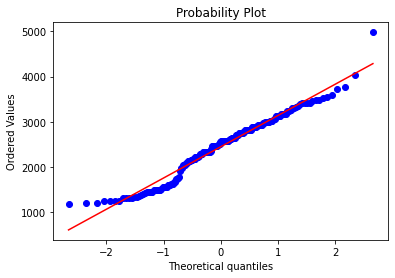

In [22]:
#perform shapiro test using predefined function shapiro_result
shapiro_result(bad_sat_mean)

pvalue is 8.916763655509596e-22
We reject the null hypothesis
No significant evidence for normal distribution


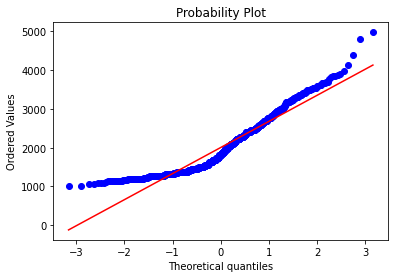

In [23]:
#perform shapiro test using predefined function shapiro_result
shapiro_result(good_sat_mean)

<a id="h1l"></a>
<h4>Checking for equal variance with Levene Test</h4>

<span style='font-family:sabon;font-size:13pt;'>
  <b>H0: The two arrays have equal variance. <br> H1: The two arrays do not have equal variance </b>
</span>

In [24]:
#use predefined function to show results of levene test
levene_result(good_sat_mean,bad_sat_mean)

pvalue is 0.5549401257830607
We cannot reject the null hypothesis
There is significant evidence for equal variance


<a id="h1t"></a>
<h4>Performing the T-test</h4>

In [25]:
#use predefined function to show results of ttest
ttest_ind_result(good_sat_mean,bad_sat_mean,equal_var = True)

pvalue is 3.3103188946127685e-14
We reject the null hypothesis


sample_1      sample_2 alpha p_value reject_h0
0  good_sat_mean  bad_sat_mean  0.05     0.0         1

_____________________________________________



<a id='h1mw'></a>
<h3>Performing a Non-Parametric Test</h3>

<span style='font-family:sabon;font-size:13pt;'>
    Since the distribution of the data is not normal, we will use another test that is non parametric and disregards the distribution of the data - the Mann Whitney Test
</span>

In [26]:
mann_whitney_result(good_sat_mean,bad_sat_mean)

Significance Level: 0.05
pvalue is 0.0000
We reject the null hypothesis
No significant evidence that the two statistical populations are the same


sample_1 sample_1_avg      sample_2 sample_2_avg alpha p_value  \
0  good_sat_mean      2006.12  bad_sat_mean      2449.08  0.05     0.0   

  reject_h0  
0         1

<a id="hypo_conc"></a>
<h3>Conclusion</h3>
<span style='font-family:sabon;font-size:13pt;'>
  <b>The result of the t-test and Mann Whitney U suggests that the two samples don't belong to the same statistical population.</b>
  <br> This means that there is a statistically significant difference between the average duration of rides on rainy saturdays versus non-rainy saturdays and as we examined in the analysis section, <a href='#IQR_weather'>
    <b>average ride duration during bad weather is longer</b>
  </a>. <br>
  <br>
</span>

<a id="overall_conc"></a>
<h2>Overall Conclusion</h2>

<span style='font-family:sabon;font-size:13pt;'> We set out to determine popular locales and effects of weather on ride duration. <br> We received the relevant data and cleaned it for analysis. <br>
  <br>
  <b>
    <u>During our analysis we have found that</u>
  </b>: <br>
  <li>
    <b>Loop</b> is the most frequented location, followed closely by <b>River North</b>
  </li>
  <li>
    <b>Flash Cab</b> is the most used service for Taxi/Ride-sharing
  </li>
  <li>The sampled data concerning Saturday rides from Loop to O'Hare International Airport suggests that <b>rides in rainy weather take longer than rides in good weather</b>
  </li>
  <br>
  <br> In order to examine the perceived notion that rides in bad weather take longer, we employed a statistical test on the two samples (ride durations in good weather versus ride duration in bad weather). <br>
  <br>
  <b>
    <u>The Results of the test show:</u>
  </b>
  <br> There is a statistically significant difference between the average ride duration in bad weather versus good weather, <b>coupling this result with our analysis suggests that bad weather does indeed increase ride duration</b>
</span>